<a href="https://colab.research.google.com/github/susmitha22/COVID-19-PREDICTOR/blob/main/IndiaLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df_confirmed = pd.read_csv(url)

In [3]:
df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,46516,46718,46837,46837,47072,47306,47516,47716,47851,48053,48116,48229,48527,48718,48952,49161,49378,49621,49681,49817,50013,50190,50433,50655,50810,50886,51039,51280,51350,51405,51526,51526,51526,51526,53011,53105,53105,53207,53332,53400
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,39014,39719,40501,41302,42148,42988,43683,44436,45188,46061,46863,47742,48530,49191,50000,50637,51424,52004,52542,53003,53425,53814,54317,54827,55380,55755,56254,56572,57146,57727,58316,58316,58991,59438,59623,60283,61008,61705,62378,63033
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,84152,85084,85927,86730,87502,88252,88825,89416,90014,90579,91121,91638,92102,92597,93065,93507,93933,94371,94781,95203,95659,96069,96549,97007,97441,97857,98249,98631,98988,99311,99610,99897,100159,100408,100645,100873,101120,101382,101657,101913
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6790,6842,6904,6955,7005,7050,7084,7127,7162,7190,7236,7288,7338,7382,7382,7446,7466,7519,7560,7577,7602,7633,7669,7699,7756,7806,7821,7875,7919,7983,8049,8117,8166,8192,8249,8308,8348,8348,8489,8586
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15251,15319,15361,15493,15536,15591,15648,15729,15804,15925,16061,16161,16188,16277,16362,16407,16484,16562,16626,16644,16686,16802,16931,17029,17099,17149,17240,17296,17371,17433,17553,17568,17608,17642,17684,17756,17864,17974,18066,18156


In [4]:
country = "India"

In [5]:
df_confirmed1 = df_confirmed[df_confirmed["Country/Region"] == country]

In [6]:
df_confirmed1

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,12/9/20,12/10/20,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20,12/21/20,12/22/20,12/23/20,12/24/20,12/25/20,12/26/20,12/27/20,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21
146,NaN,India,20.593684,78.96288,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,9499413,9534964,9571559,9608211,9644222,9677203,9703770,9735850,9767371,9796744,9826775,9857029,9884100,9906165,9932547,9956557,9979447,10004599,10031223,10055560,10075116,10099066,10123778,10146845,10169118,10187850,10207871,10224303,10244852,10266674,10266674,10286709,10323965,10340469,10356844,10374932,10395278,10413417,10413417,10450284


In [7]:
## structuring times eries data
df_confirmed2 = pd.DataFrame(df_confirmed1[df_confirmed1.columns[4:]].sum(),columns=["confirmed"])
df_confirmed2.index = pd.to_datetime(df_confirmed2.index,format='%m/%d/%y')
df_confirmed2.tail()


,confirmed
2021-01-05,10374932
2021-01-06,10395278
2021-01-07,10413417
2021-01-08,10413417
2021-01-09,10450284


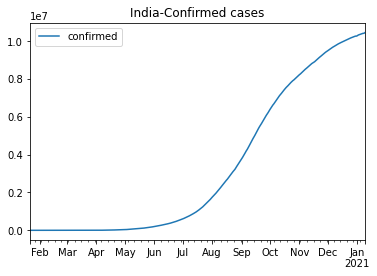

In [8]:
df_confirmed2.plot(title="India-Confirmed cases")

In [9]:
df_new = df_confirmed2[["confirmed"]]
df_new.tail(10)

,confirmed
2020-12-31,10266674
2021-01-01,10286709
2021-01-02,10323965
2021-01-03,10340469
2021-01-04,10356844
2021-01-05,10374932
2021-01-06,10395278
2021-01-07,10413417
2021-01-08,10413417
2021-01-09,10450284


In [10]:
x = len(df_new)-5
train=df_new.iloc[:x]
test = df_new.iloc[x:]
train


,confirmed
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-12-31,10266674
2021-01-01,10286709
2021-01-02,10323965
2021-01-03,10340469


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) #find max value

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
scaled_train = scaler.transform(train)#and divide every point by max value
scaled_test = scaler.transform(test)
print(scaled_train[-5:])

[[0.99129368]
 [0.99322815]
 [0.99682538]
 [0.99841892]
 [1.        ]]


In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)
generator = TimeseriesGenerator(scaled_train,scaled_train,length = n_input,batch_size=1)
x,y = generator[50]
(x.shape,y.shape)

((1, 5, 1), (1, 1))

In [17]:
(x,y)

(array([[[7.04847925e-06],
         [7.91746984e-06],
         [9.84856004e-06],
         [1.09106597e-05],
         [1.14899867e-05]]]), array([[1.37107405e-05]]))

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
model = Sequential()
model.add(LSTM(150,activation="relu",input_shape=(n_input,n_features)))
#model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dense(units=1))
#model.add(Activation('softmax'))
#model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 75)                11325     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [20]:
validation_set = np.append(scaled_train[55],scaled_test)
validation_set=validation_set.reshape(6,1)
validation_set

array([[1.37107405e-05],
       [1.00174648e+00],
       [1.00371098e+00],
       [1.00546238e+00],
       [1.00546238e+00],
       [1.00902205e+00]])

In [21]:
n_input = 5
n_features = 1
validation_gen = TimeseriesGenerator(validation_set,validation_set,length=5,batch_size=1)
validation_gen[0][0].shape,validation_gen[0][1].shape

((1, 5, 1), (1, 1))

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
model.fit_generator(generator,validation_data=validation_gen,epochs=100,callbacks=[early_stop],steps_per_epoch=10)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 2s 61ms/step - loss: 0.2181 - val_loss: 0.7906
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 0.2052 - val_loss: 0.5214
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.1289 - val_loss: 0.2447
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0281 - val_loss: 0.0903
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0150 - val_loss: 0.0422
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0475
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 4.6651e-04 - val_loss: 0.0400
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 8.6148e-04 - val_loss: 0.0326
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 6.7013e-04 - val_loss: 0.0557
Epoch 10/100
10/10 [==============================] - 0s 9ms/step - loss: 5.3567e-04 - val_los

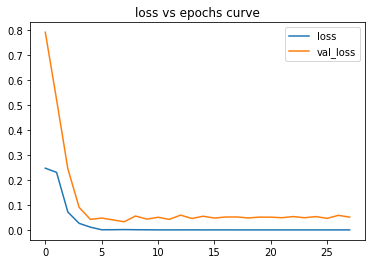

In [23]:
pd.DataFrame(model.history.history).plot(title="loss vs epochs curve")

In [24]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

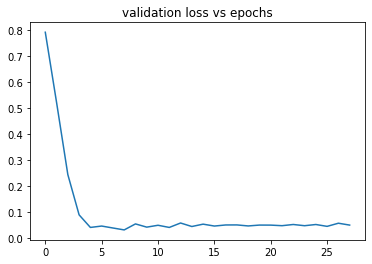

In [25]:
myloss = model.history.history["val_loss"]
plt.title("validation loss vs epochs")
plt.plot(range(len(myloss)),myloss)

**FORECAST** 

In [26]:
test_prediction = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)
current_batch.shape

(1, 5, 1)

In [27]:
## how far in future we can predict
for i in range(len(test)+7):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    test_prediction

In [28]:
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([11074902.27616072, 11251941.09935236, 11474676.12269163,
       11734120.45973969, 12057254.5239253 , 12455896.21289825,
       12777465.99832058, 13136740.21085596, 13532858.31198978,
       13968503.15709114, 14433161.85455036, 14917278.35256958])

In [29]:
time_series_array = test.index
for k in range(0,7):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16'],
              dtype='datetime64[ns]', freq=None)

In [30]:
df_forecast = pd.DataFrame(columns=["confirmed","confirmed_predicted"],index=time_series_array)
df_forecast.loc[:,"confirmed_predicted"] = true_prediction[:,0]
df_forecast.loc[:,"confirmed"] = test["confirmed"]
df_forecast

,confirmed,confirmed_predicted
2021-01-05,10374932.0,1.107490e+07
2021-01-06,10395278.0,1.125194e+07
2021-01-07,10413417.0,1.147468e+07
2021-01-08,10413417.0,1.173412e+07
2021-01-09,10450284.0,1.205725e+07
2021-01-10,NaN,1.245590e+07
2021-01-11,NaN,1.277747e+07
2021-01-12,NaN,1.313674e+07
2021-01-13,NaN,1.353286e+07
2021-01-14,NaN,1.396850e+07


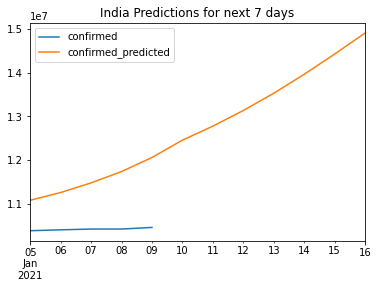

In [31]:
df_forecast.plot(title="India Predictions for next 7 days")

In [34]:
MAPE = np.mean(np.abs(np.array(df_forecast["confirmed"][:5]) - np.array(df_forecast["confirmed_predicted"][:5]))/np.array(df_forecast["confirmed"][:5]))
print("MAPE is " + str(MAPE*100) + " %")

MAPE is 10.64777994723597 %


In [35]:
sum_errs = np.sum((np.array(df_forecast["confirmed"][:5]) - np.array(df_forecast["confirmed_predicted"][:5]))**2)
stdev = np.sqrt(1/(5-2) * sum_errs)
interval = 1.96 * stdev
df_forecast["confirm_min"] = df_forecast["confirmed_predicted"] - interval
df_forecast["confirm_max"] = df_forecast["confirmed_predicted"] + interval
df_forecast

,confirmed,confirmed_predicted,confirm_min,confirm_max
2021-01-05,10374932.0,1.107490e+07,8.150906e+06,1.399890e+07
2021-01-06,10395278.0,1.125194e+07,8.327945e+06,1.417594e+07
2021-01-07,10413417.0,1.147468e+07,8.550680e+06,1.439867e+07
2021-01-08,10413417.0,1.173412e+07,8.810124e+06,1.465812e+07
2021-01-09,10450284.0,1.205725e+07,9.133258e+06,1.498125e+07
2021-01-10,NaN,1.245590e+07,9.531900e+06,1.537989e+07
2021-01-11,NaN,1.277747e+07,9.853470e+06,1.570146e+07
2021-01-12,NaN,1.313674e+07,1.021274e+07,1.606074e+07
2021-01-13,NaN,1.353286e+07,1.060886e+07,1.645685e+07
2021-01-14,NaN,1.396850e+07,1.104451e+07,1.689250e+07


In [36]:
df_forecast["Model Accuracy"] = round((1-MAPE),2)
df_forecast

,confirmed,confirmed_predicted,confirm_min,confirm_max,Model Accuracy
2021-01-05,10374932.0,1.107490e+07,8.150906e+06,1.399890e+07,0.89
2021-01-06,10395278.0,1.125194e+07,8.327945e+06,1.417594e+07,0.89
2021-01-07,10413417.0,1.147468e+07,8.550680e+06,1.439867e+07,0.89
2021-01-08,10413417.0,1.173412e+07,8.810124e+06,1.465812e+07,0.89
2021-01-09,10450284.0,1.205725e+07,9.133258e+06,1.498125e+07,0.89
2021-01-10,NaN,1.245590e+07,9.531900e+06,1.537989e+07,0.89
2021-01-11,NaN,1.277747e+07,9.853470e+06,1.570146e+07,0.89
2021-01-12,NaN,1.313674e+07,1.021274e+07,1.606074e+07,0.89
2021-01-13,NaN,1.353286e+07,1.060886e+07,1.645685e+07,0.89
2021-01-14,NaN,1.396850e+07,1.104451e+07,1.689250e+07,0.89


In [37]:
from datetime import datetime
df_forecast["Country"] = country
df_forecast["Execution date"] = str(datetime.now()).split()[0]
df_forecast

,confirmed,confirmed_predicted,confirm_min,confirm_max,Model Accuracy,Country,Execution date
2021-01-05,10374932.0,1.107490e+07,8.150906e+06,1.399890e+07,0.89,India,2021-01-11
2021-01-06,10395278.0,1.125194e+07,8.327945e+06,1.417594e+07,0.89,India,2021-01-11
2021-01-07,10413417.0,1.147468e+07,8.550680e+06,1.439867e+07,0.89,India,2021-01-11
2021-01-08,10413417.0,1.173412e+07,8.810124e+06,1.465812e+07,0.89,India,2021-01-11
2021-01-09,10450284.0,1.205725e+07,9.133258e+06,1.498125e+07,0.89,India,2021-01-11
2021-01-10,NaN,1.245590e+07,9.531900e+06,1.537989e+07,0.89,India,2021-01-11
2021-01-11,NaN,1.277747e+07,9.853470e+06,1.570146e+07,0.89,India,2021-01-11
2021-01-12,NaN,1.313674e+07,1.021274e+07,1.606074e+07,0.89,India,2021-01-11
2021-01-13,NaN,1.353286e+07,1.060886e+07,1.645685e+07,0.89,India,2021-01-11
2021-01-14,NaN,1.396850e+07,1.104451e+07,1.689250e+07,0.89,India,2021-01-11


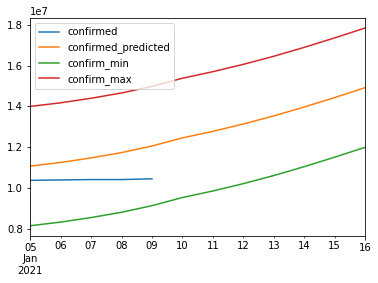

In [38]:
model.save("models/confirmed_{0}_{1}.h5".format(country,str(datetime.now()).split()[0]))
df_forecast.iloc[:,:4].plot()

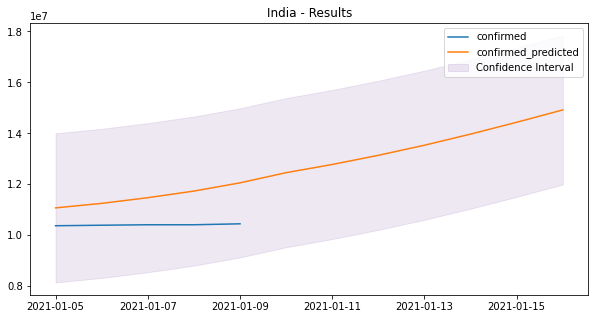

In [39]:
fig= plt.figure(figsize=(10,5))
plt.title("{} - Results".format(country))
plt.plot(df_forecast.index,df_forecast["confirmed"],label="confirmed")
plt.plot(df_forecast.index,df_forecast["confirmed_predicted"],label="confirmed_predicted")
#ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.fill_between(df_forecast.index,df_forecast["confirm_min"],df_forecast["confirm_max"],color="indigo",alpha=0.09,label="Confidence Interval")
plt.legend()
plt.show()

In [41]:
from keras.models import load_model
name = "models/confirmed_{0}_{1}.h5".format(country,str(datetime.now()).split()[0])
model1 = load_model(name)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense (Dense)                (None, 75)                11325     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________
